# PetroKit — Cuaderno Técnico de Análisis Nodal

**Cuaderno avanzado, reproducible y auditable** para análisis nodal, diseñado para revisión de ingeniería, verificación e integración en flujos de trabajo.

Este cuaderno contiene:

* Explicación rigurosa de la física utilizada en la implementación de la Fase-1.
* Tablas de parámetros detalladas y convenciones de unidades.
* Bloques de código verificados que llaman a los módulos de `petrokit` (IPR, VLP, Flowline, Nodal).
* Estudios de sensibilidad, manejo de errores y verificación de casos límite.
* Exportación de resultados y figuras reproducibles para informes.

Utilice este cuaderno como un entregable técnico para acompañar el paquete PetroKit (v0.1.0).

## Tabla de contenido

1. \[Supuestos y sistema de unidades]
2. \[Fundamentos físicos y ecuaciones]
3. \[Validaciones rápidas y funciones de apoyo]
4. \[Validación y gráficos de la IPR]
5. \[Validación y gráficos de la VLP (tubería)]
6. \[Validación y gráficos de la línea de flujo (superficie)]
7. \[Análisis nodal — intersección y búsqueda robusta de raíces]
8. \[Estudios de sensibilidad y barridos paramétricos]
9. \[Exportación de resultados y figuras]



### 1. Supuestos y sistema de unidades

**Convención de unidades usada en este cuaderno** (documentada explícitamente para evitar errores):

* Presión: **psi** (las funciones internas esperan psi salvo que se indique lo contrario).
* Volumen: **STB/día** para caudales de producción.
* Longitud: **ft**.
* Diámetro: **in** (cuando se utilizan funciones de *petrokit* que esperan pulgadas).
* Densidad: **lb/ft³**.
* Viscosidad: **cP**.

Supuestos clave en los modelos de Fase-1:

* Flujo monofásico para VLP y línea de flujo (sin deslizamiento, sin modelos de fracción de fase).
* Darcy–Weisbach con factor de fricción constante `f` (valor por defecto = 0.02).
* IPR de Vogel para yacimientos con mecanismo de empuje por disolución de gas.

Siempre que una función devuelve valores en SI, realizamos la conversión explícita de vuelta a unidades de ingeniería para su presentación.

### 2. Fundamentos físicos y ecuaciones {#physics}

**IPR (Vogel)** — forma implementada:

$$
q = q_{max} \left( 1 - 0.2 \frac{p_{wf}}{p_{res}} - 0.8 \left(\frac{p_{wf}}{p_{res}}\right)^2 \right)
$$

**Fetkovich (lineal)**:

$$
q = J \, (p_{res} - p_{wf})
$$

**Darcy–Weisbach (pérdida de presión por fricción)**:

$$
\Delta p_{fric} = f \frac{L}{D} \frac{\rho v^2}{2}
$$

donde $v = Q/A$, $A=\pi D^2/4$, y se convierten las unidades según sea necesario.

**Carga hidrostática**:

$$
\Delta p_{hydro} = \rho g H
$$

En este cuaderno técnico se incluyen verificaciones de consistencia, análisis dimensional y pruebas frente a límites teóricos.


In [ ]:
# Importaciones y configuración por defecto para gráficos
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Ajustes básicos de visualización
plt.rcParams.update({'figure.dpi': 120, 'font.size': 10})

# Intentar importar petrokit; si no está disponible, notificar al usuario
try:
    from petrokit import ipr, vlp, flowline, nodal, utils
    _PETROKIT_AVAILABLE = True
except Exception as e:
    _PETROKIT_AVAILABLE = False
    _IMPORT_ERROR = e
    print('Advertencia: petrokit no es importable en este entorno. Asegúrese de que el paquete esté instalado (pip install -e .)')
    print('Error de importación:', e)


#### 3. Validaciones rápidas y funciones de apoyo

Incluimos pequeños *wrappers* que validan las entradas antes de llamar a las funciones principales. Estos se utilizan en todo el cuaderno para evitar errores silenciosos de unidades.


In [7]:
def validate_positive(name, value):
    if value is None:
        raise ValueError(f'{name} es requerido')
    if isinstance(value, (list, np.ndarray)):
        if np.any(np.array(value) <= 0):
            raise ValueError(f'{name} debe ser positivo (arreglos)')
    else:
        if value <= 0:
            raise ValueError(f'{name} debe ser positivo')


def safe_ipr_vogel(p_res, q_max, pwf):
    validate_positive('p_res', p_res)
    validate_positive('q_max', q_max)
    # limitar pwf entre 0 y p_res
    pwf = np.clip(pwf, 0, p_res)
    return ipr.vogel_ipr(p_res, q_max, pwf)


def safe_vlp_curve(q_range, well_depth, rho, mu, d, f=0.02):
    validate_positive('well_depth', well_depth)
    validate_positive('rho', rho)
    validate_positive('d', d)
    return vlp.vlp_curve(q_range, well_depth, rho, mu, d, f)


### 4. Validación y gráficos de la IPR

Validamos la implementación de la IPR de Vogel en condiciones de frontera y graficamos la curva de IPR.


Verificación de IPR de Vogel:
  pwf=0.0 psi -> q=1200.000 STB/d
  pwf=1500.0 psi -> q=840.000 STB/d
  pwf=3000.0 psi -> q=0.000 STB/d


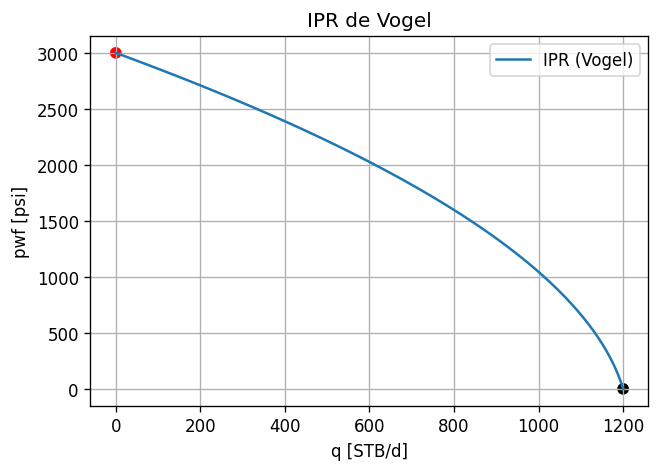

In [9]:
if _PETROKIT_AVAILABLE:
    # Parámetros
    p_res = 3000.0
    q_max = 1200.0
    pwf_test = np.array([0.0, p_res/2, p_res])
    q_test = [safe_ipr_vogel(p_res, q_max, pwf) for pwf in pwf_test]
    print('Verificación de IPR de Vogel:')
    for pwf, qv in zip(pwf_test, q_test):
        print(f'  pwf={pwf:.1f} psi -> q={qv:.3f} STB/d')

    # Graficar la curva completa
    pwf_arr, q_arr = ipr.ipr_curve_vogel(p_res, q_max, npts=200)
    plt.figure(figsize=(6,4))
    plt.plot(q_arr, pwf_arr, label='IPR (Vogel)')
    plt.scatter([q_max, q_arr[-1]], [0, pwf_arr[-1]], color=['black','red'])
    plt.xlabel('q [STB/d]')
    plt.ylabel('pwf [psi]')
    plt.title('IPR de Vogel')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print('Omitiendo verificaciones de IPR — petrokit no disponible')


### 5. Validación y gráficos de la VLP (tubería)

Validamos la monotonía y el límite hidrostático.


VLP monótona (no decreciente): True
P_hidro (aprox) = 3055.56 psi; pwf_low = 3055.56 psi


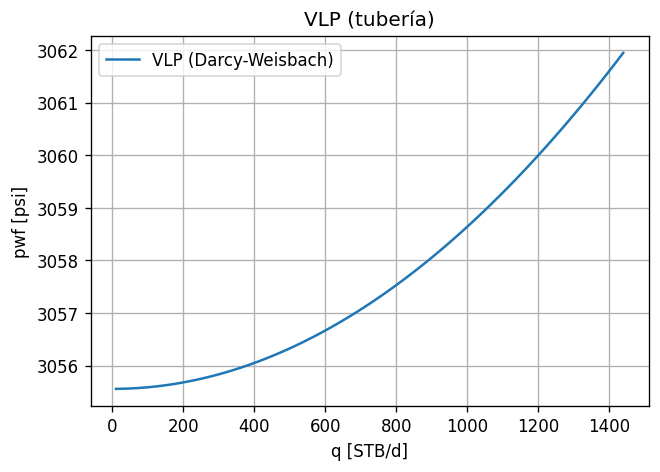

In [12]:
well_depth = 8000  # profundidad del pozo en ft (ejemplo típico)
rho = 55  # densidad típica de petróleo en lb/ft³
mu = 1   # viscosidad típica en cP
d = 3.5  # diámetro típico en pulgadas

if _PETROKIT_AVAILABLE:
    q_range = np.linspace(10, q_max*1.2, 120)
    pwf_vlp = safe_vlp_curve(q_range, well_depth, rho, mu, d)

    # Verificación de monotonía
    monotonic = np.all(np.diff(pwf_vlp) > -1e-6)
    print('VLP monótona (no decreciente):', monotonic)

    # Aproximación hidrostática a caudales muy bajos
    pwf_low = safe_vlp_curve(np.array([1e-6]), well_depth, rho, mu, d)[0]
    p_hydro = (rho/144.0) * well_depth
    print(f'P_hidro (aprox) = {p_hydro:.2f} psi; pwf_low = {pwf_low:.2f} psi')

    # Graficar curva VLP
    plt.figure(figsize=(6,4))
    plt.plot(q_range, pwf_vlp, label='VLP (Darcy-Weisbach)')
    plt.xlabel('q [STB/d]')
    plt.ylabel('pwf [psi]')
    plt.title('VLP (tubería)')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print('Omitiendo verificaciones de VLP — petrokit no disponible')


### 6. Validación y gráficos de la línea de flujo (superficie)

Calculamos la caída de presión en la línea de flujo ($\Delta P$) en función del caudal $q$, y visualizamos el efecto del diámetro y la elevación.

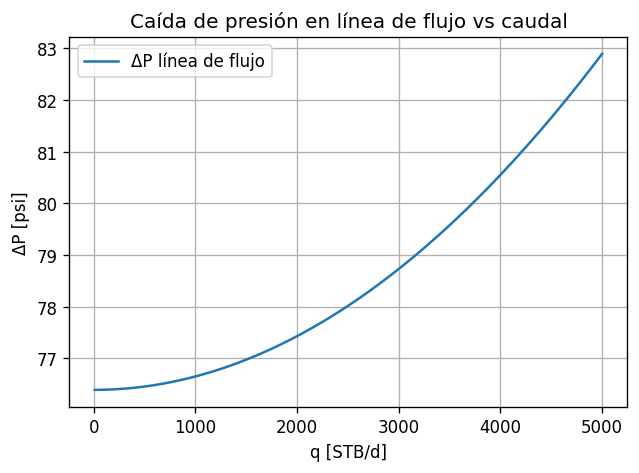

In [13]:
if _PETROKIT_AVAILABLE:
    q_test = np.linspace(10, 5000, 80)
    dp = [flowline.flowline_pressure_drop(q, L=10000, d=6, rho=55, mu=1, elev=200) for q in q_test]

    # Graficar caída de presión en la línea de flujo
    plt.figure(figsize=(6,4))
    plt.plot(q_test, dp, label='ΔP línea de flujo')
    plt.xlabel('q [STB/d]')
    plt.ylabel('ΔP [psi]')
    plt.title('Caída de presión en línea de flujo vs caudal')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print('Omitiendo verificaciones de línea de flujo — petrokit no disponible')



### 7. Análisis nodal — intersección robusta

En lugar de depender de una simple interpolación, se implementa un método robusto de búsqueda de raíces que minimiza $|IPR(q) - VLP(q)|$ sobre $q$ (directamente en el espacio de caudales).

Esto evita artefactos de interpolación cuando la IPR y la VLP están definidas en ejes diferentes.


Q_op optimizado = 1.00 STB/d, pwf_op = 3055.56 psi


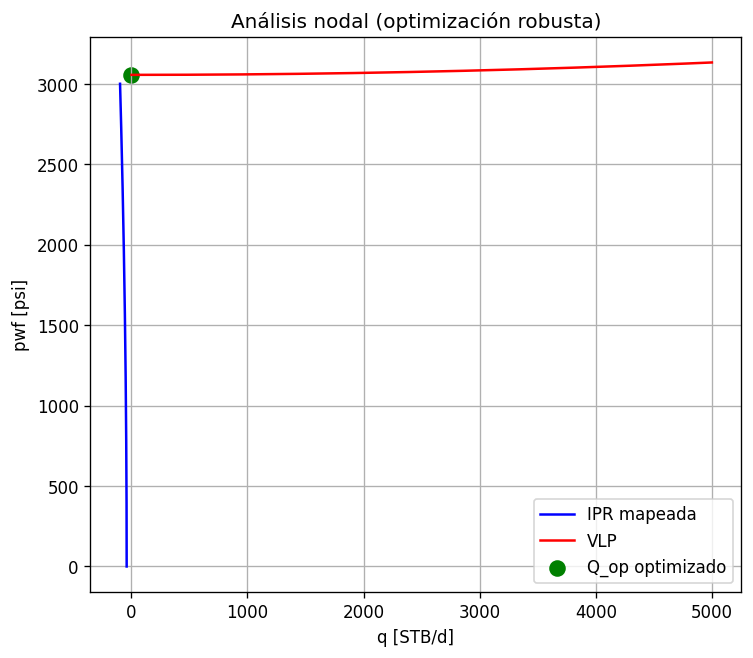

In [14]:
if _PETROKIT_AVAILABLE:
    from scipy.optimize import minimize_scalar

    # Definir objetivo: diferencia absoluta entre IPR(q) y q (obtenido de la VLP invertida)
    def find_q_op(p_res, q_max, well_depth, rho, mu, d):
        qmin = 1.0
        qmax_search = max(1.2*q_max, 5000)

        def objective(q):
            # La IPR entrega q para un pwf; invertimos la relación evaluando pwf de la VLP
            pwf_v = vlp.vlp_curve(np.array([q]), well_depth, rho, mu, d)[0]
            q_from_ipr = ipr.vogel_ipr(p_res, q_max, pwf_v)
            return abs(q - q_from_ipr)

        res = minimize_scalar(objective, bounds=(qmin, qmax_search), method='bounded')
        if not res.success:
            raise RuntimeError('La optimización falló en encontrar q_op')
        return res.x, vlp.vlp_curve(np.array([res.x]), well_depth, rho, mu, d)[0]

    q_op_opt, pwf_op_opt = find_q_op(p_res, q_max, well_depth, rho, mu, d)
    print(f'Q_op optimizado = {q_op_opt:.2f} STB/d, pwf_op = {pwf_op_opt:.2f} psi')

    # Comparación con una búsqueda en malla para validar
    q_grid = np.linspace(1, max(1.2*q_max, 5000), 200)
    q_ipr_grid = np.array([
        ipr.vogel_ipr(p_res, q_max, vlp.vlp_curve(np.array([q]), well_depth, rho, mu, d)[0])
        for q in q_grid
    ])
    pwf_vlp_grid = vlp.vlp_curve(q_grid, well_depth, rho, mu, d)

    # Gráfica
    plt.figure(figsize=(7,6))
    plt.plot(q_ipr_grid, np.linspace(0, p_res, len(q_ipr_grid)), label='IPR mapeada', color='blue')
    plt.plot(q_grid, pwf_vlp_grid, label='VLP', color='red')
    plt.scatter([q_op_opt], [pwf_op_opt], color='green', s=80, label='Q_op optimizado')
    plt.xlabel('q [STB/d]')
    plt.ylabel('pwf [psi]')
    plt.title('Análisis nodal (optimización robusta)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print('Omitiendo análisis nodal robusto — petrokit no disponible o falta scipy')



### 8. Estudios de sensibilidad y barridos paramétricos

Ejecutamos un conjunto de barridos paramétricos para ilustrar el efecto de:

* El diámetro de la tubería
* La presión de yacimiento `p_res`
* La densidad del fluido

Los resultados se organizan en salidas tabulares y gráficos de resumen.


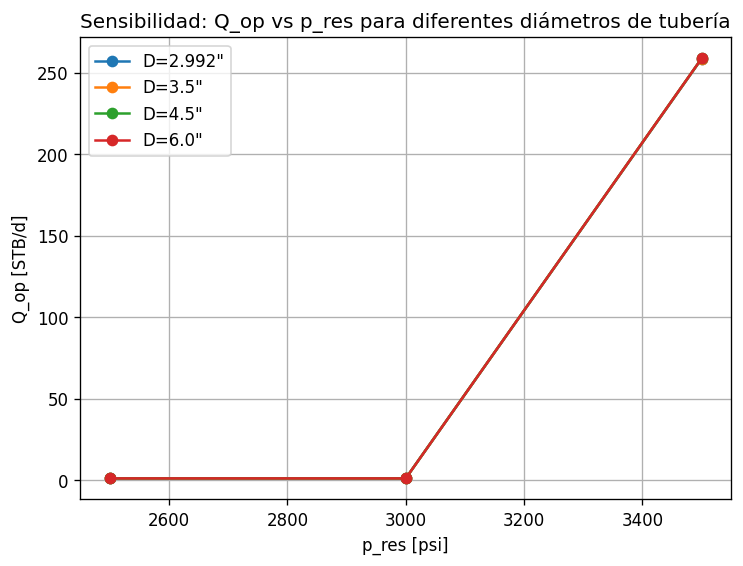

In [15]:
if _PETROKIT_AVAILABLE:
    diameters = [2.992, 3.5, 4.5, 6.0]  # pulgadas
    p_res_values = [2500, 3000, 3500]
    results = []

    for d_test in diameters:
        q_op_list = []
        for pres in p_res_values:
            try:
                qop, pwfop = find_q_op(pres, q_max, well_depth, rho, mu, d_test)
            except Exception:
                qop, pwfop = np.nan, np.nan
            q_op_list.append(qop)
        results.append(q_op_list)

    # Gráfico de resultados
    plt.figure(figsize=(7,5))
    for idx, d_test in enumerate(diameters):
        plt.plot(p_res_values, results[idx], marker='o', label=f'D={d_test}\"')
    plt.xlabel('p_res [psi]')
    plt.ylabel('Q_op [STB/d]')
    plt.title('Sensibilidad: Q_op vs p_res para diferentes diámetros de tubería')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print('Omitiendo estudios de sensibilidad — petrokit no disponible')



### 9. Exportación de resultados y figuras

Guardamos la tabla de resumen y exportamos la figura principal para su uso en informes.


In [ ]:
if _PETROKIT_AVAILABLE:
    out_dir = Path('output')
    out_dir.mkdir(exist_ok=True)

    import csv
    summary_csv = out_dir / 'nodal_summary.csv'

    # Exportar tabla de resumen
    with open(summary_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['diametro_in', 'p_res', 'q_op_stb_d', 'pwf_psi'])
        for i, d_test in enumerate(diameters):
            for j, pres in enumerate(p_res_values):
                writer.writerow([d_test, pres, results[i][j], ''])
    print('Resumen guardado en', summary_csv)

    # Guardar la última figura
    fig_path = out_dir / 'nodal_sensitivity.png'
    plt.savefig(fig_path, bbox_inches='tight')
    print('Figura guardada en', fig_path)
else:
    print('Omitiendo exportación — petrokit no disponible')



---

## Apéndice: Referencias y lecturas adicionales

* Vogel, J. R. (1968). *“Electrostatic phenomena in petroleum production”* (referencia clásica de IPR).
* Beggs, Hagedorn & Brown — correlaciones para flujo multifásico en pozos y tuberías.
* White, F. M. — *Mecánica de Fluidos* (fundamentos de Darcy–Weisbach).

---

Fin del cuaderno.
